# Custos Médicos 🧑‍⚕️

Este projeto tem como objetivo prever os valores médicos de custos individuais cobrados pelo seguro de saúde. Para esse trabalho, vamos utilizar a base de dados [Insurance](https://www.kaggle.com/datasets/mirichoi0218/insurance?resource=download) obtida no site [Kaggle](https://www.kaggle.com/).

### 1- Analisando a base

In [19]:
# Fazendo os imports necessários
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [2]:
insurance = pd.read_csv('../data/insurance.csv')

In [3]:
insurance.shape

(1338, 7)

In [4]:
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [5]:
insurance.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [7]:
insurance.corr(numeric_only=True)

,age,bmi,children,charges
age,1.000000,0.109272,0.042469,0.299008
bmi,0.109272,1.000000,0.012759,0.198341
children,0.042469,0.012759,1.000000,0.067998
charges,0.299008,0.198341,0.067998,1.000000


Como temos duas colunas textuais, Smoker e Region, vamos converter essas colunas para números de forma que seja possível trabalhar com elas em nosso modelo caso tenham relevância.

In [9]:
set(insurance['smoker'])

{'no', 'yes'}

In [10]:
set(insurance['region'])

{'northeast', 'northwest', 'southeast', 'southwest'}

In [13]:
label_encoder = LabelEncoder()
insurance['sex'] = label_encoder.fit_transform(insurance['sex'])
insurance['smoker'] = label_encoder.fit_transform(insurance['smoker'])
insurance['region'] = label_encoder.fit_transform(insurance['region'])
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,3,16884.92400
1,18,1,33.770,1,0,2,1725.55230
2,28,1,33.000,3,0,2,4449.46200
3,33,1,22.705,0,0,1,21984.47061
4,32,1,28.880,0,0,1,3866.85520


In [14]:
# Verificando se existem dados nulos
insurance.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [16]:
insurance.corr()

,age,sex,bmi,children,smoker,region,charges
age,1.000000,-0.020856,0.109272,0.042469,-0.025019,0.002127,0.299008
sex,-0.020856,1.000000,0.046371,0.017163,0.076185,0.004588,0.057292
bmi,0.109272,0.046371,1.000000,0.012759,0.003750,0.157566,0.198341
children,0.042469,0.017163,0.012759,1.000000,0.007673,0.016569,0.067998
smoker,-0.025019,0.076185,0.003750,0.007673,1.000000,-0.002181,0.787251
region,0.002127,0.004588,0.157566,0.016569,-0.002181,1.000000,-0.006208
charges,0.299008,0.057292,0.198341,0.067998,0.787251,-0.006208,1.000000


### Criando um mapa de calor para entendermos melhor a correlação entre os dados

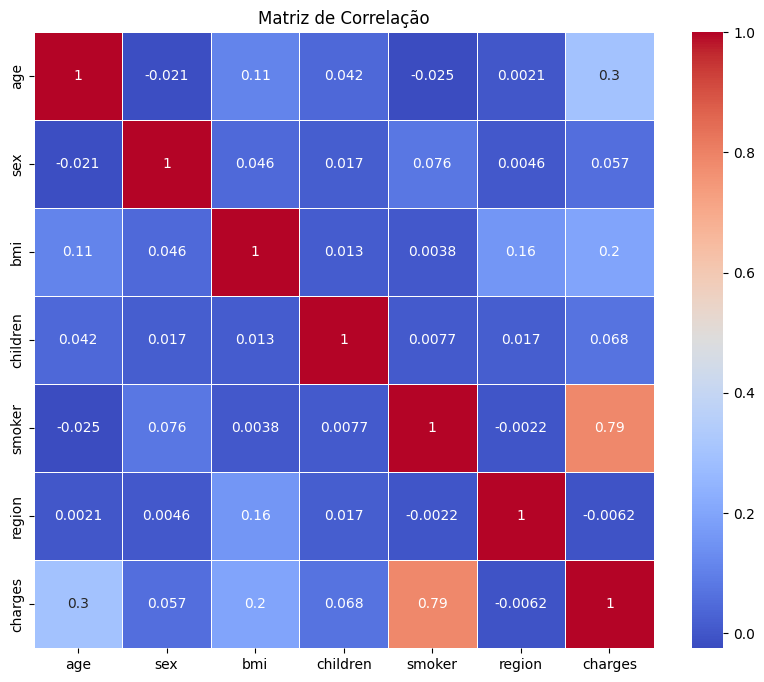

In [18]:
plt.figure(figsize=(10, 8))
sns.heatmap(insurance.corr(), cmap='coolwarm', annot=True, linewidths=0.5)
plt.title('Matriz de Correlação')
plt.show()

Podemos verificar na matriz de correlação que, o fato de a pessoa ser fumante esta muito relacionado com o preço do seguro de saúde, seguido pela idade e bmi, as demais colunas não aparentam ter uma correlação tão significativa.

### 2 - Treinando um modelo de Regressão Linear

Vamos treinar um modelo com os dados da forma que estão, sem aplicar PCA e Normalização de dados, vamos ver o desempenho do modelo nesse formato.

Como os valores são muito diferentes, vamos normalizar os dados para que estejam em uma mesma proporção

In [ ]:
scaler = StandardScaler()